# Title: Google Play App Store Sentiment Analysis of Customer Reviews

### Data Source
- Kaggle: https://www.kaggle.com/lava18/google-play-store-apps

### Abstract
Each word in the lexicon has scores for:
- polarity: negative vs. positive    (-1.0 => +1.0)
- subjectivity: objective vs. subjective (+0.0 => +1.0)

### Import Libraries

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
import regex as re
import spacy
import en_core_web_sm
from string import punctuation
import category_encoders as ce

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
file = 'DATA/googleplaystore_user_reviews.csv'
df = pd.read_csv(file)

### Data wrangling

In [3]:
df.shape

(64295, 5)

In [4]:
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [5]:
df.App.value_counts()

CBS Sports App - Scores, News, Stats & Watch Live    320
Bowmasters                                           320
Angry Birds Classic                                  320
Helix Jump                                           300
8 Ball Pool                                          300
                                                    ... 
Dresses Ideas & Fashions +3000                        31
Detector de Radares Gratis                            31
Easy Healthy Recipes                                  31
Drawing Clothes Fashion Ideas                         30
Easy Hair Style Design                                30
Name: App, Length: 1074, dtype: int64

- the dataset represents 1074 Google Play Mobile Apps with Reviews ranging from 30 - 320 per app

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [7]:
df.isnull().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

In [8]:
# drop rows with null or nan values
df = df.dropna()

In [9]:
# change names of columns
df.columns = ['app', 'review', 'sentiment', 'polarity', 'subjectivity']

In [10]:
df.head()

,app,review,sentiment,polarity,subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [11]:
# Remove app column
df.drop(['app', 'subjectivity'], axis='columns', inplace=True)

In [12]:
df

,review,sentiment,polarity
0,I like eat delicious food. That's I'm cooking ...,Positive,1.000000
1,This help eating healthy exercise regular basis,Positive,0.250000
3,Works great especially going grocery store,Positive,0.400000
4,Best idea us,Positive,1.000000
5,Best way,Positive,1.000000
...,...,...,...
64222,Most ads older many agents ..not much owner po...,Positive,0.173333
64223,"If photos posted portal load, fit purpose. I'm...",Positive,0.225000
64226,"Dumb app, I wanted post property rent give opt...",Negative,-0.287500
64227,I property business got link SMS happy perform...,Positive,0.800000


### Staging for text cleaning

In [13]:
nlp = en_core_web_sm.load()

### Prepare the text

This stage involves all the text handling and preparation concerned with the changes and modifications from the raw source text to a format that will be used for the actual processing, things like:
- handle encoding
- handle extraneous and international charaters
- handle symbols
- handle metadata and embeded information
- handle repetitions (such multiple spaces or newlines)

In [14]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)
    return text

In [15]:
%%time
text_cleaned = []
for text in df.review:
    text_cleaned.append(clean_text(text))

Wall time: 492 ms


In [16]:
df.review = text_cleaned

### Work the text
Concern with the meaning and the substance of the content to extract actual information.

In [17]:
def convert_text(text):
    '''
    Remove StopWords, and Lemmatize etc.
    '''
    # remove punctuation
    text = text.translate(str.maketrans('', '', punctuation))
    # remove anything that is not alphanumeric or underscore
    doc = nlp(text)
    converted_text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return converted_text

In [18]:
%%time
df['short'] = df.review.apply(convert_text)

Wall time: 3min 28s


In [19]:
df.sample(10)

,review,sentiment,polarity,short
45060,Someone posted no. In I getting annoyed this. ...,Negative,-0.400000,post getting annoy Remove Ill report cyber cell
34569,Buy it. No ads.,Neutral,0.000000,buy ad
20138,Okay don't want install things wallpaper stuff,Positive,0.500000,okay nt want install thing wallpaper stuff
1378,The spinning wheel rigged. Other dont get play...,Negative,-0.260714,spinning wheel rig nt play people rank nt rank...
5101,"Doesn't show actual position plane, expected p...",Negative,-0.050000,nt actual position plane expect position base ...
20431,Tons ads know they're desperate profits Fake N...,Negative,-0.292857,ton ad know desperate profit Fake News rating ...
61087,It's lovely game problem many adds. Again vide...,Positive,0.050000,lovely game problem add video come budge app m...
25391,I loved rewards offered CVS gift cards recent ...,Positive,0.350000,love reward offer CVS gift card recent update ...
4051,Very accurate diagnosing pain. Much better web...,Positive,0.438105,accurate diagnose pain well webmd second revie...
13391,Lost locations again! I used last 4 phones. Th...,Negative,-0.012500,lose location 4 phone way want upgrade order w...


### Perform basic EDA

In [20]:
# this shows the aggregate distinct values of the target variable can be multinomial
df.sentiment.value_counts()

Positive    23998
Negative     8271
Neutral      5158
Name: sentiment, dtype: int64

- Fortunately the dataset is large or there won't be enough training examples of all categories to fit the model

In [21]:
df_neg = df.loc[(df.sentiment == 'Negative')]

In [22]:
text_neg = ''
for text in df_neg.review:
    text_neg += text + ' '

In [23]:
cloud_neg = WordCloud().generate(str(text_neg))

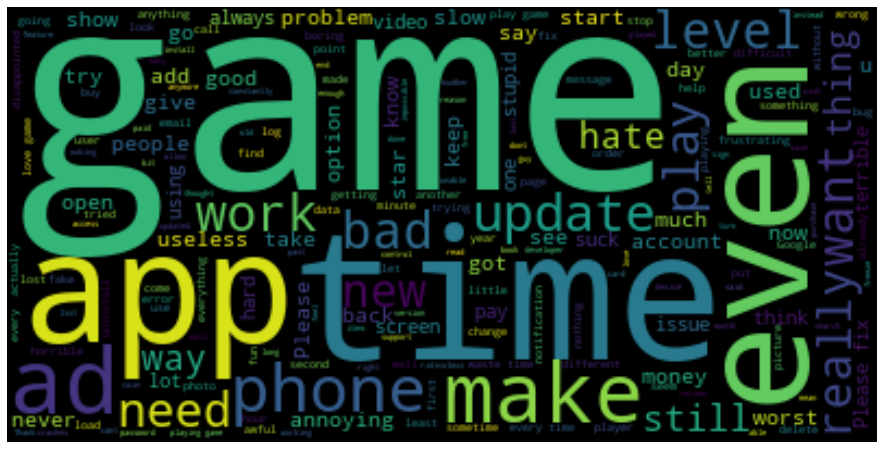

In [24]:
plt.figure(figsize=(16,8))
plt.imshow(cloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
df_neut = df.loc[(df.sentiment == 'Neutral')]

In [26]:
text_neut = ''
for text in df_neut.review:
    text_neut += text + ' '

In [27]:
cloud_neut = WordCloud().generate(str(text_neut))

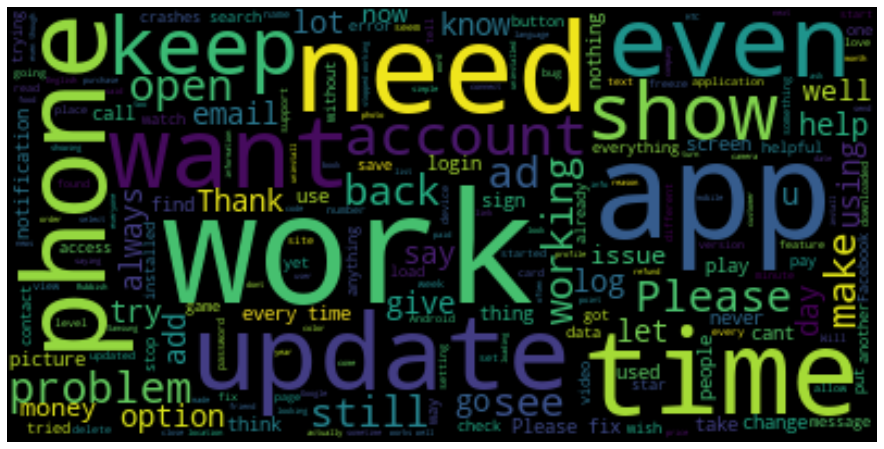

In [28]:
plt.figure(figsize=(16,8))
plt.imshow(cloud_neut, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
df_pos = df.loc[(df.sentiment == 'Positive')]

In [30]:
%%time
text_pos = ''
for text in df_pos.review:
    text_pos += text + ' '

Wall time: 677 ms


In [31]:
cloud_pos = WordCloud().generate(str(text_pos))

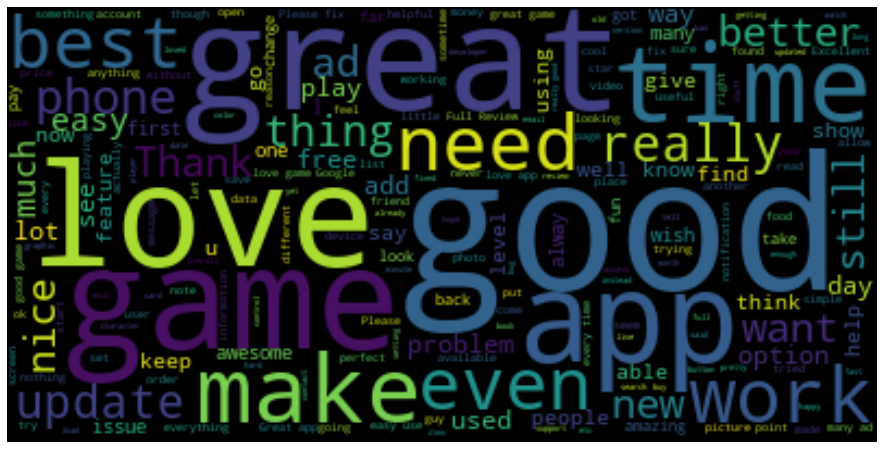

In [32]:
plt.figure(figsize=(16,8))
plt.imshow(cloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

In [33]:
df.dtypes

review        object
sentiment     object
polarity     float64
short         object
dtype: object

#### Map code to sentiment

Should we keep the neutral class in our data set since it only is relevent when polarity = 0?

From Wikipedia: "Even though in most statistical classification methods, the neutral class is ignored under the assumption that neutral texts lie near the boundary of the binary classifier, several researchers suggest that, as in every polarity problem, three categories must be identified. Moreover, it can be proven that specific classifiers such as the Max Entropy and SVMs can benefit from the introduction of a neutral class and improve the overall accuracy of the classification."

Source: https://en.wikipedia.org/wiki/Sentiment_analysis

In [34]:
codes = {'Negative':-1, 'Neutral':0, 'Positive':1}

In [35]:
df['sentiment'] = df.sentiment.map(codes)

In [36]:
df.dtypes

review        object
sentiment      int64
polarity     float64
short         object
dtype: object

#### Describe distribution

In [37]:
df.describe()

,sentiment,polarity
count,37427.000000,37427.000000
mean,0.420205,0.182171
std,0.828029,0.351318
min,-1.000000,-1.000000
25%,0.000000,0.000000
50%,1.000000,0.150000
75%,1.000000,0.400000
max,1.000000,1.000000


- Polarity is simply the scalar version of sentiment, and hence should only be included in the model to estimate a regressor and of a classifier
- The collinearity between sentiment and polarity is further reinforced by the positive skewness of the boxplots, where outliers towards the negative side of polarity are many.
- Subjectivity denotes the objectivity and subjectivity of text respectively
- Dataset need not be scaled as original values should be preserved to represent the nominal scales

### Selecting features and splitting data

In [38]:
# Features and Labels
X = df['short']
y = df['sentiment'] 

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [39]:
# create classifiers using GridSearchCV
params_log = {'penalty': ['l1','l2'], 
             'C': np.logspace(-4, 4, 10)}
clf_log = GridSearchCV(LogisticRegression(random_state=42, multi_class='multinomial'), params_log, cv=2)

params_SVC = {'C': [0.1,1, 10, 100], 
             'gamma': [1,0.1,0.01,0.001],
             'kernel': ['rbf', 'poly', 'sigmoid']}
clf_SVC = GridSearchCV(SVC(probability=True, random_state=42), params_SVC, cv=10)

params_SGD = {'penalty': ['l1','l2', 'elasticnet'], 
             'alpha': ['0.0001','0.001','0.01','0.1','1.0']}
clf_SGD = GridSearchCV(SGDClassifier(random_state=42), params_SGD, cv=10)

params_NB = {'alpha': ['0.0001','0.001','0.01','0.1', '1.0']}
clf_NB = GridSearchCV(MultinomialNB(), params_NB)

params_KNN = {'metric': ['euclidean', 'manhattan'],
 'n_neighbors': np.arange(1, 16)}
clf_KNN = GridSearchCV(KNeighborsClassifier(), params_KNN, cv=10)

params_dt = {'criterion': ['entropy', 'gini'], 'max_depth': np.arange(3, 15),
            'min_samples_leaf': np.arange(3, 15)}
clf_dt = GridSearchCV(DecisionTreeClassifier(), params_dt, cv=10)

In [70]:
params_log = {'penalty': ['l1','l2'], 'C': np.logspace(-4, 4, 10)}
clf_log = GridSearchCV(LogisticRegression(random_state=42, multi_class='multinomial'), params_log, cv=5)

In [71]:
# create classifiers using RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

param_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

clf_rf = RandomizedSearchCV(RandomForestClassifier(), 
                            param_distributions = param_rf, 
                            n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

### Feature Engineering

#### Bag-of-words

In [41]:
# create a matrix of word counts from the text
counts = CountVectorizer()

In [42]:
# do the actual counting
A = counts.fit_transform(X_train, y_train)

In [43]:
A.shape

(29941, 18864)

In [52]:
B = counts.transform(X_test)

In [ ]:
# fit logistic regression
clf_log.fit(A.toarray(), y_train)

In [68]:
clf_log.best_estimator_

LogisticRegression(multi_class='multinomial', random_state=42)

In [66]:
clf_log.classes_

array([-1,  0,  1], dtype=int64)

In [67]:
clf_log.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'multinomial',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': 42,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(multi_class='multinomial', random_state=42),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'penalty': ['l1', 'l2']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [69]:
clf_log.score(B.toarray(), y_test)

0.896874165108202

In [56]:
pred_log = clf_log.predict(B.toarray())

In [59]:
pred_log

array([ 1,  0, -1, ...,  1,  1,  1], dtype=int64)